## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
import torch.nn as nn

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, train_test_split

from fastai.collab import *
from fastai.tabular import *
from fastai.tabular.all import *
from fastai.callback import *

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import fastai

print(f'PyTorch version: {torch.__version__}')
print('*'*10)

print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

print(f'Pandas version: {pd.__version__}')
print(f'fastai version: {fastai.__version__}')

PyTorch version: 1.12.0+cu102
**********
CUDNN version: 7605
Available GPU devices: 1
Device Name: Tesla K80
Pandas version: 2.0.0
fastai version: 2.7.12


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [6]:
%%time
df = pd.read_csv('vader_sent_filtered_philly_295k.csv')

CPU times: user 2.24 s, sys: 307 ms, total: 2.55 s
Wall time: 6.82 s


In [7]:
df.shape

(295003, 10)

In [8]:
df.head()

,business_id,user_id,text,stars,date,res_avg_stars,review_count,user_id_cat,business_id_cat,nltk_sentiment
0,kxX2SOes4o-D3ZQBkiMRfA,DVMopL-MS3_03qMW0Dxa1A,"I've been here several times. The price is reasonable, food is quite good, and the service as well. I've always ordered take-out. One time I went, and the guy who normally takes my order wasn't there... Instead there were 2 ladies... I think one was the wife of the owner. Or something along those lines. Anyway they were nice but when I came back to pick up my order they handed me the wrong bag (someone else's order). They should have confirmed the contents, but frankly I should have as well, so I accept at least part of the blame. I ended up going all the way home before I realized the scr...",4.0,2014-11-13 20:50:21,4.0,181,0,0,0.9451
1,AmI3LIUNwsi4023hOVGu3w,DVMopL-MS3_03qMW0Dxa1A,"The wife and I have never been to Moshulu, though we always drove by there whenever we take cruises or tool around in that part of the city. So for this date night I said what the heck, let's give this overpriced joint a try and see if it's worth it. The wait staff was nice, albeit not QUITE as responsive as I'd have liked for an upscale joint. The food was decent, portions weren't too giant, and our tummies were satisfied. \n\nThe calamari was tasty enough for me (though not quite as tasty for the wife). The dumplings were tasty, and the NINE DOLLAR FRIES were especially yummy. Pretty muc...",4.0,2017-09-26 18:16:06,3.5,874,0,1342,0.9845
2,wGnBaLvgH3hrq6C3AnO5Mg,DVMopL-MS3_03qMW0Dxa1A,"Since the very first time I discovered and visited this establishment, I've been hooked. Their [uniformed] waiter/waitress service is ""Russian Good"" (don't expect lots of smiles and fawning... they get straight to the point).\n\nJust about everything on the menu is tasty... the sweet potato french fries, beef or chicken samsas, veal liver, cow tongue, avocado salad... hell, even the rice pilaf is well-flavored (not necessarily ""spicy"" but well-seasoned). I don't ever remember having to add salt to my dishes.. and that's saying a lot, since I add salt and hot sauce to almost everything.\n\n...",4.0,2015-06-14 00:04:04,3.5,93,0,2065,0.9798
3,fYSaoJMOj7-r4XWEuYjRxw,DVMopL-MS3_03qMW0Dxa1A,"This is SPECIFICALLY for the Afro-Beat Sunday, which is what I had the most experience with (twice so far). I'll keep it quick.\n\nPROS\n1. No cover on Sunday night\n2. Big-booty and fine-looking waitresses (and cute bartender guy, as my female cousin said)\n3. Strong drinks - I had the Long Island Ice Tea, and was tipsy within 50% of it.\n4. Good chicken wings.\n5. Fairly diverse mix of people, by age, race, ethnicity, and apparent socioeconomic class.\n\nCONS\n1. Music is LOUD. WAY TOO LOUD. Deafening. I think I might need a cochlea implant after this.\n\n2. Just as we were about to danc...",3.0,2016-07-11 13:58:52,2.5,215,0,2500,0.6562
4,mXNKjKkq7Zk6-39_t4c5OA,DVMopL-MS3_03qMW0Dxa1A,"After being very unwelcome at Zarafshon (see my review of that Russian mobster joint), we thought hey let's go next door and give the Indian folks our business. Once again, our group of 5 well-dressed professional adults walked in, the guy came out (no greeting, nothing), we said we wanted to place a large take-out order, and he LITERALLY told us, ""Oh no I'm so busy tonight I can't take any order"", waved us away and walked back in.\n\nSo much for American Capitalism. I've never been so racially profiled all in 1 night. Maybe I might go back to this place and talk to the manager about what ...",3.0,2014-11-11 04:11:31,4.0,9,0,2765,0.9929


### Data Preparation

In [9]:
df = df[['user_id_cat', 'business_id_cat', 'res_avg_stars', 'review_count', 'nltk_sentiment', 'stars']]

In [10]:
df

,user_id_cat,business_id_cat,res_avg_stars,review_count,nltk_sentiment,stars
0,0,0,4.0,181,0.9451,4.0
1,0,1342,3.5,874,0.9845,4.0
2,0,2065,3.5,93,0.9798,4.0
3,0,2500,2.5,215,0.6562,3.0
4,0,2765,4.0,9,0.9929,3.0
...,...,...,...,...,...,...
294998,10726,4837,3.5,41,0.9665,4.0
294999,10726,5192,4.0,23,0.9857,4.0
295000,10726,5271,3.0,57,0.1250,2.0
295001,10726,5696,4.5,42,0.9873,5.0


In [11]:
# Compute average sentiment score for each restaurant
avg_res_sentiment_df = df.groupby('business_id_cat')['nltk_sentiment'].mean().reset_index().rename(columns={'nltk_sentiment': 'avg_res_sentiment'})
avg_res_sentiment_df.head()

,business_id_cat,avg_res_sentiment
0,0,0.851986
1,1,0.755726
2,2,0.745231
3,3,0.836924
4,4,0.831195


In [12]:
embed_df = pd.merge(df, avg_res_sentiment_df, on='business_id_cat', how='left')
embed_df = embed_df.drop('nltk_sentiment', axis=1)
embed_df = embed_df[['user_id_cat', 'business_id_cat', 'res_avg_stars', 'review_count', 'avg_res_sentiment', 'stars']]
embed_df

,user_id_cat,business_id_cat,res_avg_stars,review_count,avg_res_sentiment,stars
0,0,0,4.0,181,0.851986,4.0
1,0,1342,3.5,874,0.790914,4.0
2,0,2065,3.5,93,0.703277,4.0
3,0,2500,2.5,215,0.635389,3.0
4,0,2765,4.0,9,0.830550,3.0
...,...,...,...,...,...,...
294998,10726,4837,3.5,41,0.633663,4.0
294999,10726,5192,4.0,23,0.903925,4.0
295000,10726,5271,3.0,57,0.739628,2.0
295001,10726,5696,4.5,42,0.961263,5.0


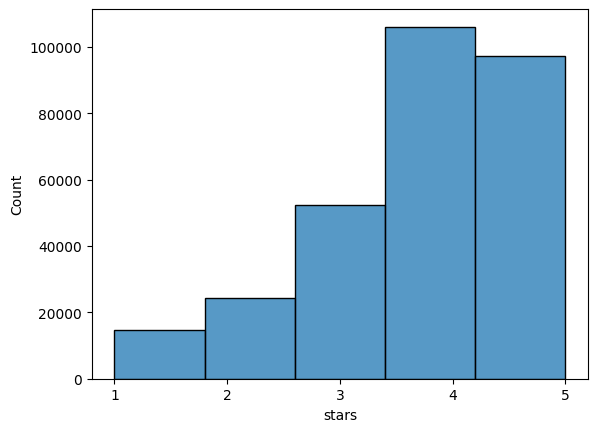

In [13]:
# Plot star ratings distribution
sns.histplot(embed_df['stars'], binwidth=0.8)
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [14]:
embed_df

,user_id_cat,business_id_cat,res_avg_stars,review_count,avg_res_sentiment,stars
0,0,0,4.0,181,0.851986,4.0
1,0,1342,3.5,874,0.790914,4.0
2,0,2065,3.5,93,0.703277,4.0
3,0,2500,2.5,215,0.635389,3.0
4,0,2765,4.0,9,0.830550,3.0
...,...,...,...,...,...,...
294998,10726,4837,3.5,41,0.633663,4.0
294999,10726,5192,4.0,23,0.903925,4.0
295000,10726,5271,3.0,57,0.739628,2.0
295001,10726,5696,4.5,42,0.961263,5.0


In [47]:
embed_df[embed_df.duplicated()]

,user_id_cat,business_id_cat,res_avg_stars,review_count,avg_res_sentiment,stars


In [45]:
unique_user = len(embed_df['user_id_cat'].unique())
unique_resto = len(embed_df['business_id_cat'].unique())
print(f'Total number of unique users: {unique_user}')
print(f'Total number of unique restaurants: {unique_resto}')

Total number of unique users: 10727
Total number of unique restaurants: 5795


## Splitting Data

In [29]:
# Split data using 80:20 ratio
train_df_dot, test_df_dot = train_test_split(embed_df, test_size=0.2, random_state=123)

## EmbeddingDotBias Model

In [30]:
y_name = 'stars'

# Select number of latent factors for the EmbeddingDotBias model (matrix factorization)
n_factors = 60

# Create the model by using collab_learner from fastai
# Train using all data without validation set to get all user and restaurant bias in the dataset
collab_dls = CollabDataLoaders.from_df(train_df_dot, valid_pct=0.2, seed=123, user_name='user_id_cat', item_name='business_id_cat', rating_name=y_name, device=device)
learn_dot = collab_learner(collab_dls, n_factors=n_factors, y_range=(1, 5), wd=1e-1)
learn_dot.model = learn_dot.model.to(device)

In [31]:
# EmbeddingDotBias model architecture
learn_dot.model

EmbeddingDotBias(
  (u_weight): Embedding(10728, 60)
  (i_weight): Embedding(5665, 60)
  (u_bias): Embedding(10728, 1)
  (i_bias): Embedding(5665, 1)
)

SuggestedLRs(valley=0.019054606556892395)

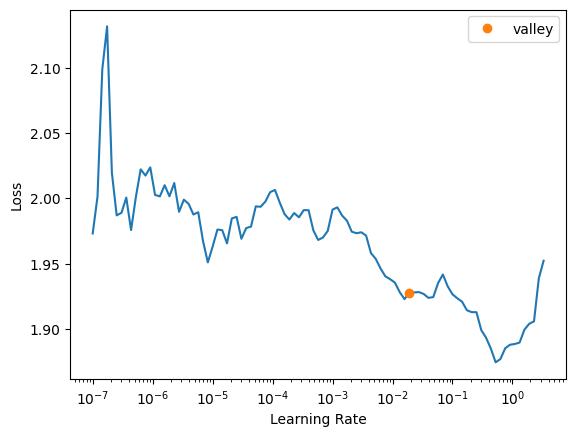

In [32]:
# Use fastai's lr_find() to get suggested learning rate
learn_dot.lr_find()

In [33]:
# Train the EmbeddingDotBias model
learn_dot.fit_one_cycle(10, 0.019) #loss function: MSELossFlat

epoch,train_loss,valid_loss,time
0,1.171339,1.171691,00:20
1,1.203682,1.219113,00:20
2,1.225976,1.227035,00:20
3,1.225370,1.216002,00:20
4,1.214949,1.193984,00:20
5,1.126273,1.155000,00:20
6,1.111838,1.120535,00:20
7,0.999374,1.081979,00:20
8,0.819021,1.069511,00:20
9,0.678870,1.069948,00:20


In [34]:
# Define function to calculate model performance (RMSE and MAE)
def calculate_dot_test_metrics(learn_model, model_name):
    test_dl = learn_model.dls.test_dl(test_df_dot)
    sub = learn_model.get_preds(dl=test_dl)

    # Compute the test RMSE
    y_preds = sub[0].numpy()
    y_true = sub[1].numpy()
    test_rmse = mean_squared_error(y_true, y_preds) ** 0.5
    print(f'{model_name} Test RMSE: {test_rmse}' )
    test_mae = mean_absolute_error(y_true, y_preds)
    print(f'{model_name} Test MAE: {test_mae}')
    
    return (test_rmse, test_mae)

# base_test_metrics = calculate_test_metrics(learn_dot, 'Base Model')
base_test_metrics = calculate_dot_test_metrics(learn_dot, 'EmbeddingDotBias Model')

EmbeddingDotBias Model Test RMSE: 1.0321535140565499
EmbeddingDotBias Model Test MAE: 0.831743061542511


In [35]:
learn_dot.export('dot_model.pkl') # model export

We could see that the EmbeddingDotBias Model are performing really well on train set, but the test RMSE is still high, which explains overfitting. However, we could retrieve the user's and restaurant's bias and use it as additional features for our neural network model.

### Feature Engineering using EmbeddingDotBias (latent factor method to retrieve user's and restaurant's bias)

In [49]:
# Create the model by using collab_learner from fastai for the whole dataset
collab_dls = CollabDataLoaders.from_df(df, valid_pct=0, seed=123, user_name='user_id_cat', item_name='business_id_cat', rating_name=y_name, device=device)
learn_dot = collab_learner(collab_dls, n_factors=n_factors, y_range=(1, 5), wd=1e-1)
learn_dot.model = learn_dot.model.to(device)
learn_dot.model

EmbeddingDotBias(
  (u_weight): Embedding(10728, 60)
  (i_weight): Embedding(5796, 60)
  (u_bias): Embedding(10728, 1)
  (i_bias): Embedding(5796, 1)
)

SuggestedLRs(valley=0.019054606556892395)

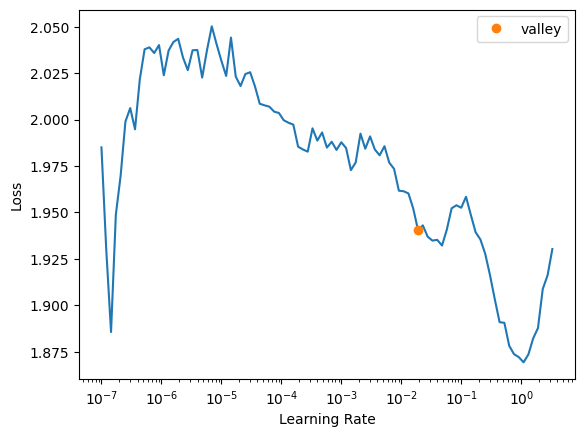

In [41]:
# Use fastai's lr_find() to get suggested learning rate
learn_dot.lr_find()

In [36]:
# For EmbeddingDotBias model visualization
class EmbeddingDotBiasModule(nn.Module):
    def __init__(self, n_factors, n_users, n_items, y_range=None):
        super().__init__()
        self.embedding_dot_bias = EmbeddingDotBias(n_factors, n_users, n_items, y_range=y_range)
        
    def forward(self, x):
        return self.embedding_dot_bias(x)

model = EmbeddingDotBiasModule(n_factors=60, n_users=10728, n_items=5796)
print(model)
X = torch.LongTensor([[1, 2], [3, 4]])
y = model(X)
dot = make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.render('EmbeddingDotBias_viz', format='png')

EmbeddingDotBiasModule(
  (embedding_dot_bias): EmbeddingDotBias(
    (u_weight): Embedding(10728, 60)
    (i_weight): Embedding(5796, 60)
    (u_bias): Embedding(10728, 1)
    (i_bias): Embedding(5796, 1)
  )
)


'EmbeddingDotBias_viz.png'

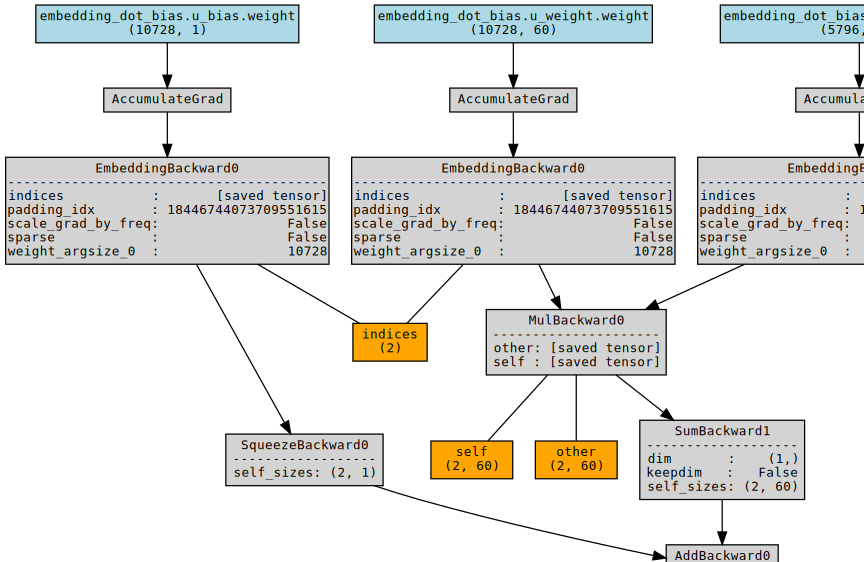

In [19]:
dot

In [45]:
# Train the EmbeddingDotBias model
learn_dot.fit_one_cycle(10, 0.02) #loss function: MSELossFlat

epoch,train_loss,valid_loss,time
0,1.170582,None,00:27
1,1.203453,None,00:27
2,1.244491,None,00:27
3,1.217307,None,00:27
4,1.179308,None,00:27
5,1.160555,None,00:27
6,1.139209,None,00:27
7,1.033406,None,00:27
8,0.949766,None,00:27
9,0.863977,None,00:27


In [47]:
losses = np.array(learn_dot.recorder.values)
best_train_rmse = np.min(losses[:, 0]) ** 0.5
print('Best Train RMSE:', best_train_rmse)

Best Train RMSE: 0.9295037993691511


### Retrieve bias for users and restaurants, adding it as training features

In [49]:
resto_count = df.groupby('business_id_cat')['stars'].count()
resto_count.sort_values(ascending=False)[:10]

business_id_cat
5224    1591
4668    1291
1201    1285
2364    1141
634     1106
3495    1008
1794     951
3498     949
637      886
4083     879
Name: stars, dtype: int64

In [51]:
restos_idx = resto_count.sort_values(ascending=False).index.values
resto_bias = learn_dot.bias(restos_idx, is_item=True)
mean_ratings_resto = df.groupby('business_id_cat')['stars'].mean()
resto_ratings_bias = [(b, i, mean_ratings_resto.loc[i], resto_count.loc[i]) for i,b in zip(restos_idx, resto_bias)]

item0 = lambda o:o[0]
sorted_resto_bias = sorted(resto_ratings_bias, key=item0)
sorted_resto_bias_df = pd.DataFrame(sorted_resto_bias, columns=['resto_bias', 'business_id_cat', 'avg_pred_stars', 'total_reviews'])
sorted_resto_bias_df['resto_bias'] = sorted_resto_bias_df['resto_bias'].apply(lambda x: x.numpy())
sorted_resto_bias_df

,resto_bias,business_id_cat,avg_pred_stars,total_reviews
0,-0.418398,1776,2.273616,614
1,-0.385746,3149,1.280000,25
2,-0.365251,4839,2.109589,73
3,-0.360753,809,1.527778,36
4,-0.319066,1842,1.875000,40
...,...,...,...,...
5790,0.749199,2396,4.812950,139
5791,0.785729,3558,4.477679,448
5792,0.849251,1201,4.522179,1285
5793,0.868614,4649,4.628415,549


In [52]:
user_count = df.groupby('user_id_cat')['stars'].count()
user_count.sort_values(ascending=False)

user_id_cat
220      706
606      608
170      538
438      466
517      438
        ... 
7950      10
9817      10
9816      10
5505      10
10726     10
Name: stars, Length: 10727, dtype: int64

In [53]:
users_idx = user_count.sort_values(ascending=False).index.values
users_bias = learn_dot.bias(users_idx, is_item=False)
mean_ratings_user = df.groupby('user_id_cat')['stars'].mean()
users_ratings = [(b, i, mean_ratings_user.loc[i], user_count.loc[i]) for i,b in zip(users_idx, users_bias)]

item0 = lambda o:o[0]
sorted_users_bias = sorted(users_ratings, key=item0)
sorted_users_bias_df = pd.DataFrame(sorted_users_bias, columns=['user_bias', 'user_id_cat', 'avg_pred_stars_given', 'total_reviews_given'])
sorted_users_bias_df['user_bias'] = sorted_users_bias_df['user_bias'].apply(lambda x: x.numpy())
sorted_users_bias_df

,user_bias,user_id_cat,avg_pred_stars_given,total_reviews_given
0,-0.370588,6538,1.272727,22
1,-0.334064,5670,1.210526,19
2,-0.323080,9383,1.000000,19
3,-0.301571,3450,1.781250,32
4,-0.272296,943,2.129630,54
...,...,...,...,...
10722,0.631546,4618,4.103627,193
10723,0.681244,1137,4.958904,73
10724,0.684404,2524,4.526316,228
10725,0.726669,501,4.404412,272


In [60]:
dl_df = pd.merge(embed_df, sorted_resto_bias_df[['business_id_cat', 'resto_bias']], on='business_id_cat', how='left')
dl_df = pd.merge(dl_df, sorted_users_bias_df[['user_id_cat', 'user_bias']], on='user_id_cat', how='left')
dl_df = dl_df[['user_id_cat', 'business_id_cat', 'res_avg_stars', 'review_count', 'avg_res_sentiment', 'user_bias', 'resto_bias', 'stars']]
dl_df.rename(columns={'review_count': 'res_review_count'}, inplace=True)
dl_df

,user_id_cat,business_id_cat,res_avg_stars,res_review_count,avg_res_sentiment,user_bias,resto_bias,stars
0,0,0,4.0,181,0.851986,-0.027455,0.367758,4.0
1,0,1342,3.5,874,0.790914,-0.027455,0.171414,4.0
2,0,2065,3.5,93,0.703277,-0.027455,0.137784,4.0
3,0,2500,2.5,215,0.635389,-0.027455,-0.097630,3.0
4,0,2765,4.0,9,0.830550,-0.027455,0.061210,3.0
...,...,...,...,...,...,...,...,...
294998,10726,4837,3.5,41,0.633663,0.014713,0.087498,4.0
294999,10726,5192,4.0,23,0.903925,0.014713,0.111554,4.0
295000,10726,5271,3.0,57,0.739628,0.014713,0.071674,2.0
295001,10726,5696,4.5,42,0.961263,0.014713,0.244893,5.0


In [452]:
dl_df.to_csv('dl_df.csv', index=False)

## Deep Learning model using fastai's tabular learner

In [203]:
dl_df = pd.read_csv('dl_df.csv')

In [204]:
# Split data using 80:20 ratio
train_df, test_df = train_test_split(dl_df, test_size=0.2, random_state=123)
test_df.to_csv('user_test_df.csv')

In [205]:
# Define the input data using TabularPandas
procs = [Categorify, FillMissing, Normalize]
cat_names = ['user_id_cat', 'business_id_cat']
cont_names = ['res_avg_stars', 'res_review_count', 'avg_res_sentiment', 'user_bias', 'resto_bias']

y_names = 'stars'
n_factors = 60

SuggestedLRs(valley=0.001737800776027143)

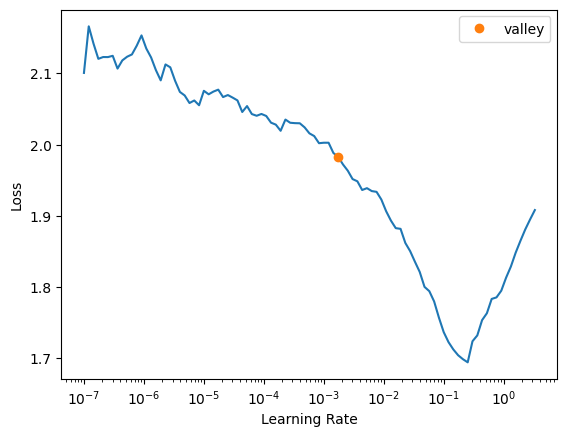

In [206]:
# Create dataloaders and base model
dls = TabularDataLoaders.from_df(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
               y_names=y_names, valid_pct=0.2, bs=128, val_bs=128, device=device)
learn_tab = tabular_learner(dls, layers=[n_factors, 100], config={'ps':[0.3, 0.1], 'embed_p':0.2, 'bn_final':False}, y_range=(1, 5), wd=1e-1, metrics=rmse)
learn_tab.model = learn_tab.model.to(device)

# Find suggested learning rate
learn_tab.lr_find()

In [207]:
# Model architecture
learn_tab.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10728, 289)
    (1): Embedding(5679, 203)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=497, out_features=60, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=60, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=1, high=5)
  )
)

In [212]:
# Train the model for 10 epochs and suggested learning rate
learn_tab.fit_one_cycle(10, 0.0017)

epoch,train_loss,valid_loss,_rmse,time
0,0.685757,1.104964,1.051172,00:17
1,0.781145,1.024006,1.011932,00:17
2,0.829000,0.997748,0.998873,00:17
3,0.817950,1.001257,1.000628,00:17
4,0.779931,1.020261,1.010080,00:17
5,0.746451,1.060026,1.029576,00:17
6,0.684708,1.115694,1.056264,00:17
7,0.612241,1.142692,1.068968,00:17
8,0.555963,1.166991,1.080274,00:17
9,0.519988,1.190424,1.091066,00:17


In [213]:
# Define function to calculate model performance (RMSE and MAE)
def calculate_test_metrics(learn_model, model_name):
    test_dl = learn_model.dls.test_dl(test_df)
    sub = learn_model.get_preds(dl=test_dl)

    # Compute the test RMSE
    y_preds = sub[0].numpy()
    y_true = sub[1].numpy()
    test_rmse = mean_squared_error(y_true, y_preds) ** 0.5
    print(f'{model_name} Test RMSE: {test_rmse}' )
    test_mae = mean_absolute_error(y_true, y_preds)
    print(f'{model_name} Test MAE: {test_mae}')
    
    return (test_rmse, test_mae)

In [214]:
# base_test_metrics = calculate_test_metrics(learn_dot, 'Base Model')
base_test_metrics = calculate_test_metrics(learn_tab, 'Base Model')

Base Model Test RMSE: 1.087168811923662
Base Model Test MAE: 0.8168315887451172


In [215]:
learn_tab.export('tab_base_model.pkl')

From the training results, it seems that the model is overfitting. Although the train_loss achieved a very good result, MSE Loss = 0.73 at the 10th epoch but when testing it on unseen data, the RMSE is not better than the previous models without deep learning.

## Hyperparameter Tuning with Bayes Optimization

In [223]:
# Define model fitting function with Stratified 5-fold Cross Validation
def fit_with(lr:float, wd:float, dropout1:float, dropout2:float, lin_layer:int):
    
    print('=============== Params ===================')
    print(lr, float(wd), dropout1, dropout2, int(lin_layer))

    config = {'ps': [dropout1, dropout2], 'embed_p': 0.2}
    
    # Perform stratified k-fold cross-validation
    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

    for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df[y_names])):
        print(f"Training fold {fold+1}/{n_folds}")
        
        split_idxs.append([train_idx, valid_idx])
        
        dls = TabularDataLoaders.from_df(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, valid_idx=valid_idx, bs=128, val_bs=128, device=device)
        
        learn = tabular_learner(dls, layers=[n_factors, int(lin_layer)], config=config, y_range=(1, 5), wd=float(wd), metrics=rmse)
        learn.model = learn.model.to(device)
    
        with learn.no_bar() and learn.no_logging():
            learn.fit_one_cycle(10, float(lr))
        
        val_loss = float(learn.validate()[1])
#         print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}")
        valid_losses.append(val_loss)

    avg_loss = np.mean(valid_losses)
    print(f"Average Validation Loss: {avg_loss:.4f}\n")
    
    return -avg_loss # maximize negative loss (MSE)

In [224]:
# Define hyperparameters searching space
hps = {'lr': (0.005, 0.01),
        'wd': (1e-2, 1e-1),
        'dropout1': (0.4, 0.6), 
        'dropout2': (0.2, 0.4),
        'lin_layer': (100, 200)
      }

# Create tuning function
optim = BayesianOptimization(
    f = fit_with, 
    pbounds = hps, 
    verbose = 2,
    random_state=123
)

In [225]:
%%time
optim.maximize(n_iter=5)

|   iter    |  target   | dropout1  | dropout2  | lin_layer |    lr     |    wd     |
-------------------------------------------------------------------------------------
=============== Params ===================
0.0077565738454144564 0.035247792719299315 0.5392938371195724 0.25722786699007594 122
Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


Average Validation Loss: 0.9775

| 1         | -0.9775   | 0.5393    | 0.2572    | 122.7     | 0.007757  | 0.03525   |
=============== Params ===================
0.007404659507421805 0.06470942336252646 0.4846212920248922 0.3961528396769231 168
Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


Average Validation Loss: 0.9866

| 2         | -0.9866   | 0.4846    | 0.3962    | 168.5     | 0.007405  | 0.06471   |
=============== Params ===================
0.005298389483047842 0.06417601702026118 0.4686356032301739 0.3458099414768083 143
Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


Average Validation Loss: 0.9935

| 3         | -0.9935   | 0.4686    | 0.3458    | 143.9     | 0.005298  | 0.06418   |
=============== Params ===================
0.007657756869209192 0.052135517161282056 0.5475990811464071 0.2364983460907 117
Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


Average Validation Loss: 0.9960

| 4         | -0.996    | 0.5476    | 0.2365    | 117.5     | 0.007658  | 0.05214   |
=============== Params ===================
0.008055117553387914 0.034980095568680064 0.5268801917102642 0.3698863588155579 172
Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


Average Validation Loss: 0.9986

| 5         | -0.9986   | 0.5269    | 0.3699    | 172.4     | 0.008055  | 0.03498   |


ValueError: LBFGSB - one of the lower bounds is greater than an upper bound.

The above results in an error because the tuning already resulted/found the best hyperparameter

In [226]:
# Get the best parameters which maximize the objective function which is -MSE / minimize MSE Loss
print(optim.max)
params = optim.max['params']

{'target': -0.9775304635365804, 'params': {'dropout1': 0.5392938371195724, 'dropout2': 0.25722786699007594, 'lin_layer': 122.6851453564203, 'lr': 0.0077565738454144564, 'wd': 0.035247792719299315}}


So, we have the best hyperparameters results and let's train a new neural network using this parameters

In [230]:
# Training new model with best hyperparameters
lr = params['lr']
wd = params['wd']
lin_layer = round(params['lin_layer'])
d1 = round(params['dropout1'], 1)
d2 = round(params['dropout2'], 1)

config = {'ps': [d1, d2], 'embed_p': 0.2}

dls = TabularDataLoaders.from_df(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
           y_names=y_names, valid_pct=0.2, bs=128, val_bs=128, device=device)

learn = tabular_learner(dls, layers=[n_factors, int(lin_layer)], config=config, y_range=(1, 5), wd=float(wd), metrics=rmse)
learn.model = learn.model.to(device)

# Utilize callbacks from fastai libraries
cb_save = SaveModelCallback(monitor='valid_loss') # saving weights of the model if better model is found
cb_reduce_lr = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.05, patience=2, min_lr=1e-8) # reducing learning rate if valid_loss is not decreasing
cbs = [cb_save, cb_reduce_lr]

learn.fit_one_cycle(10, float(lr), cbs=cbs)

epoch,train_loss,valid_loss,_rmse,time
0,0.934541,0.943029,0.971097,00:17
1,0.934699,0.941350,0.970232,00:19
2,0.941237,0.936138,0.967542,00:18
3,0.924801,0.923352,0.960912,00:18
4,0.928668,0.935248,0.967082,00:18
5,0.866740,0.946272,0.972765,00:18
6,0.880639,0.954821,0.977149,00:18
7,0.833089,0.987147,0.993553,00:18
8,0.796797,1.016733,1.008332,00:17
9,0.739466,1.027347,1.013581,00:17


Better model found at epoch 0 with valid_loss value: 0.9430288076400757.
Better model found at epoch 1 with valid_loss value: 0.9413500428199768.
Better model found at epoch 2 with valid_loss value: 0.9361379146575928.
Epoch 2: reducing lr to 0.000767205363123997
Better model found at epoch 3 with valid_loss value: 0.9233519434928894.
Epoch 4: reducing lr to 0.0005818403665831331
Epoch 6: reducing lr to 0.00026809286435406347
Epoch 8: reducing lr to 3.358179265189306e-05


In [418]:
learn.export('tab_best_model.pkl') # export model

In [419]:
learn = load_learner('tab_best_model.pkl')

In [420]:
# Calculate new model's performance metrics
best_test_metrics = calculate_test_metrics(learn, 'Best Params Model')

Best Params Model Test RMSE: 0.9590482671084907
Best Params Model Test MAE: 0.7451607584953308


In [421]:
# Model architecture
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10727, 289)
    (1): Embedding(5676, 202)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=496, out_features=60, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=60, out_features=123, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(123, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=123, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=1, high=5)
  )
)

## Permutation Importance

In [317]:
# Creating Features Importance Plot of best model using permutation importance calculation
# reference: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Regression_and_Permutation_Importance.ipynb
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


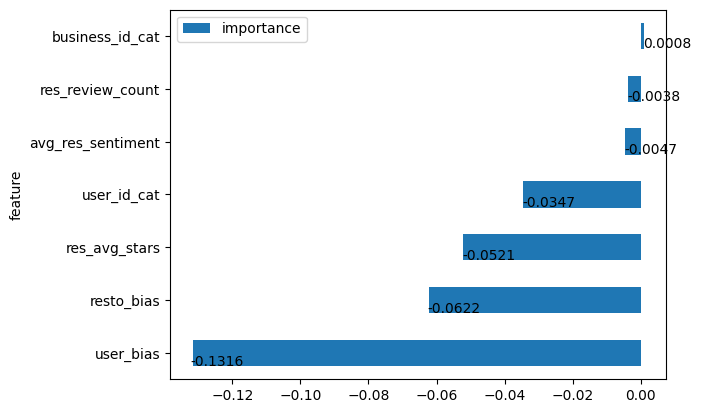

In [318]:
fi_plot_tab = PermutationImportance(learn, train_df, bs=128)

In [326]:
# For TabularModel model visualization
class TabularModelModule(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.0, y_range=None, use_bn=True):
        super().__init__()
        self.tabular_model = TabularModel(emb_szs, n_cont, out_sz, layers, ps=ps, embed_p=embed_p, y_range=y_range, use_bn=use_bn)
        
    def forward(self, x_cat, x_cont):
        return self.tabular_model(x_cat, x_cont)

model = TabularModelModule(emb_szs=[(10728, 289), (5686, 203)], n_cont=5, out_sz=1, layers=[60, 123], ps=[0.5, 0.3], embed_p=0.2, y_range=[1, 5], use_bn=True)
X_cat = torch.LongTensor([[1, 2], [3, 4]])
X_cont = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4, 0.5], [0.6, 0.7, 0.8, 0.9, 1.0]])
y = model(X_cat, X_cont)
dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.render('TabularModel_viz_with_att', format='png')

'TabularModel_viz_with_att.png'

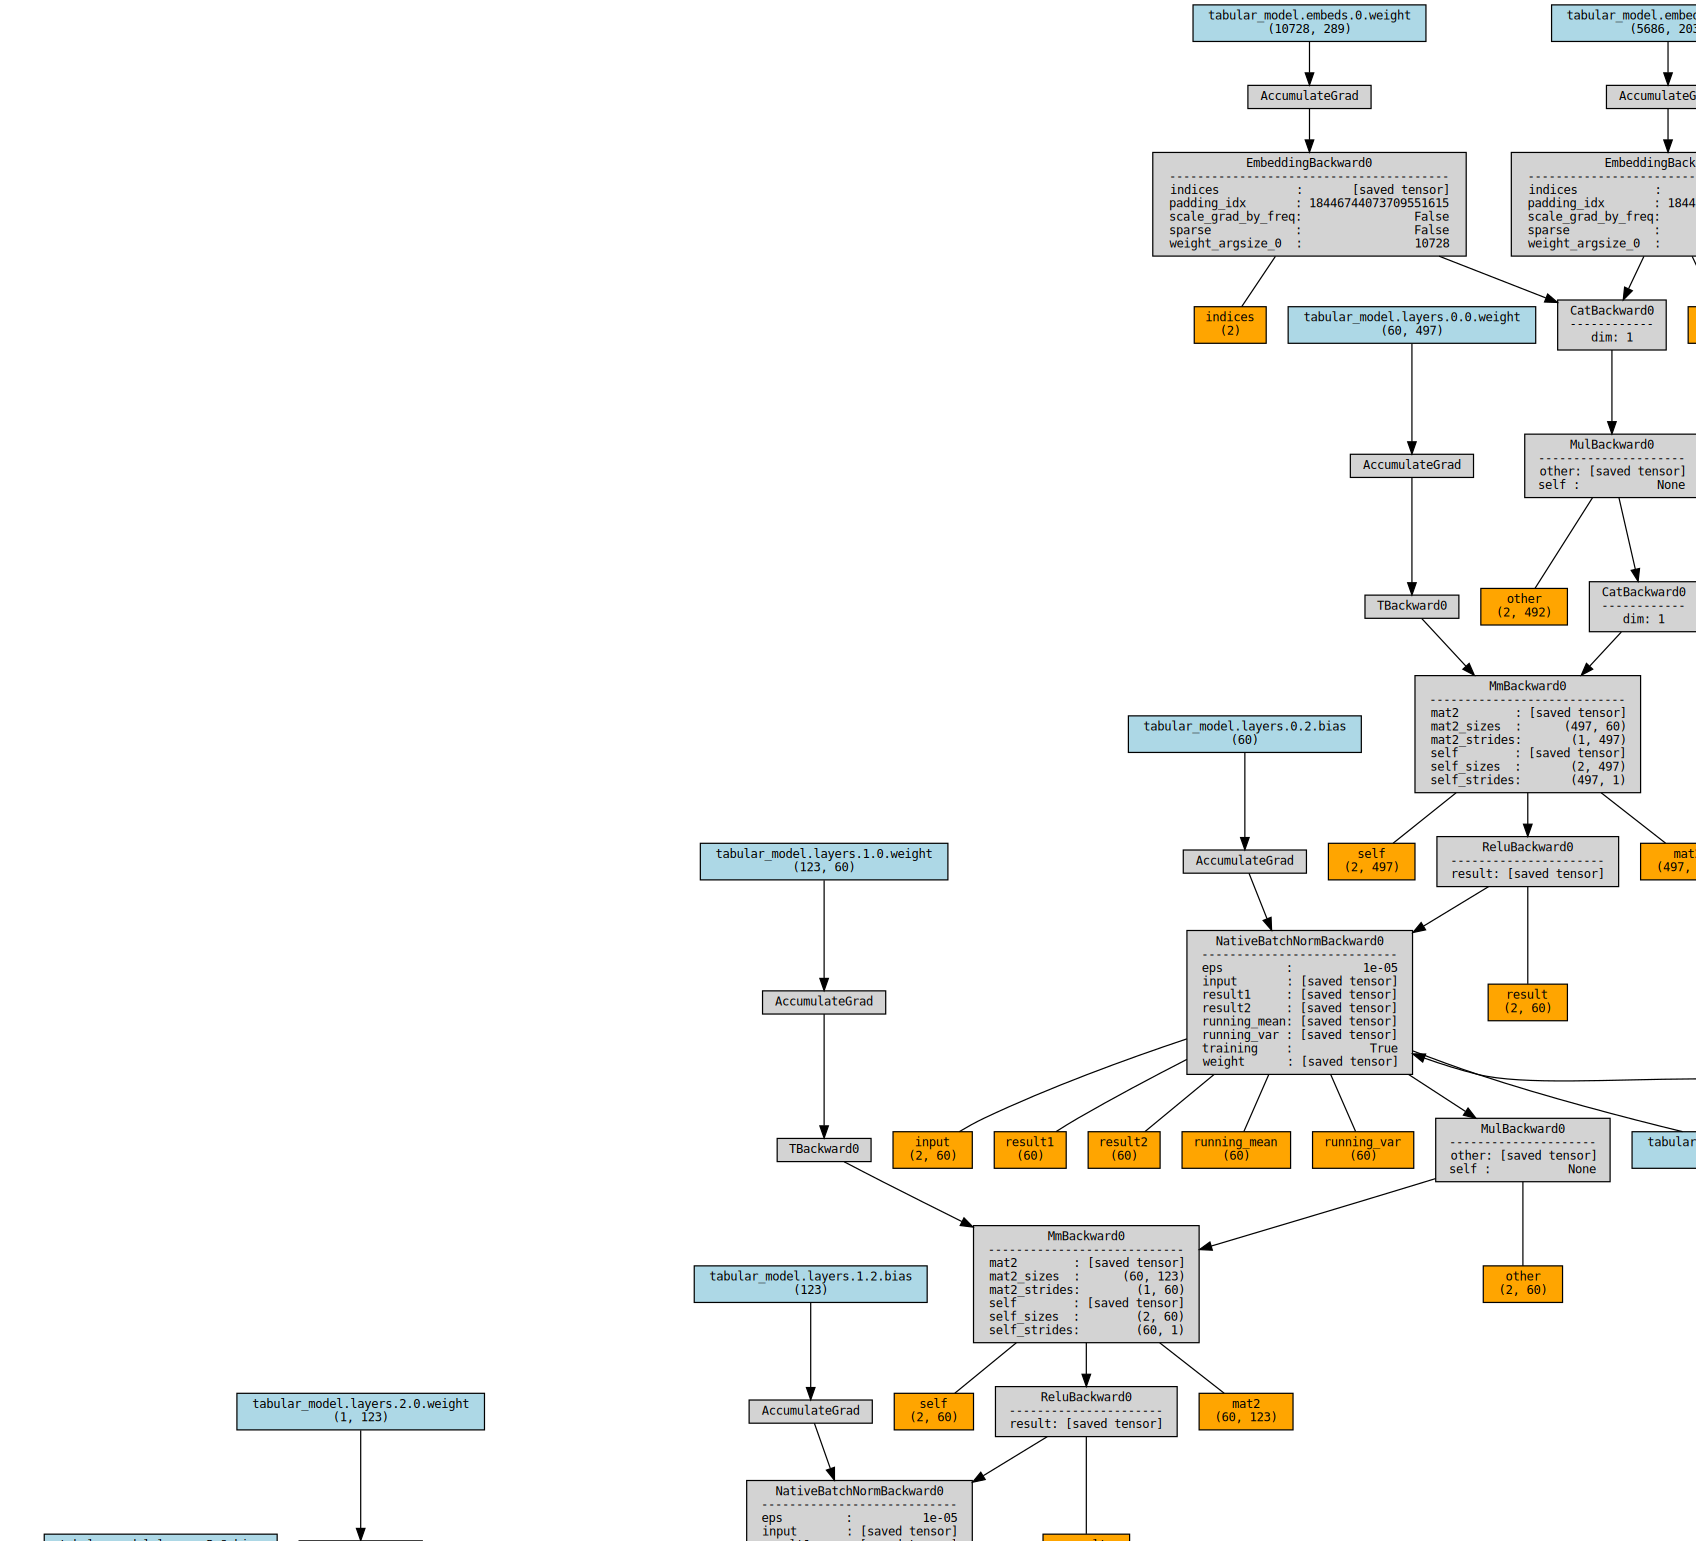

In [327]:
dot